## РК2 ММО Сефербеков М.C
## Задача 1. Классификация текстов на основе методов наивного Байеса.
## Задание
- Необходимо решить задачу классификации текстов на основе любого выбранного датасета. Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

- Необходимо сформировать признаки на основе CountVectorizer или TfidfVectorizer.

- В качестве классификаторов необходимо использовать два классификатора, не относящихся к наивным Байесовским методам (например, LogisticRegression, LinearSVC), а также Multinomial Naive Bayes (MNB), Complement Naive Bayes (CNB), Bernoulli Naive Bayes.

- Для каждого метода необходимо оценить качество классификации с помощью хотя бы двух метрик качества классификации (например, Accuracy, ROC-AUC).

- Сделать выводы о том, какой классификатор осуществляет более качественную классификацию на выбранном наборе данных.
## Выполнение


In [84]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [85]:
# Загрузка данных
messages = pd.read_csv("spam.csv")
messages = messages.iloc[:,[0,1]]
messages.columns = ["class", "message"]
messages.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [98]:
messages.shape
messages=messages.fillna('0')

In [99]:
messages['class'].unique()

array(['ham', 'spam'], dtype=object)

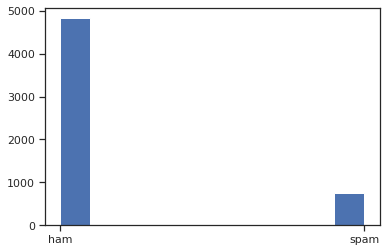

In [100]:
plt.hist(messages['class'])
plt.show()


В целевом признаке распределение классов не равномерное, поэтому в дальнейшем будем использовать функцию balanced_accuracy_score вместо функции accuracy_score

In [101]:
# Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки
vocab_list = messages['message'].tolist()
vocab_list[1:10]

['Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",
 'Even my brother is not like to speak with me. They treat me like aids patent.',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobil

In [102]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 8483


In [103]:
tfidfv = TfidfVectorizer(ngram_range=(1,3))
tfidf_ngram_features = tfidfv.fit_transform(vocab_list)
tfidf_ngram_features

<5572x102118 sparse matrix of type '<class 'numpy.float64'>'
	with 211689 stored elements in Compressed Sparse Row format>

##### Будем проверять классификаторы LinearSVC и метод К соседей.
##### В качестве наивных Байесовских используем методы Complement Naive Bayes (CNB) и Bernoulli Naive Bayes.
##### Предположительно лучшую точность среди Байесовских классификаторов покажет CNB, поскольку данный метод подходит для наборов с сильным дисбалансов классов.
##### Проверим это предположение:
Разделим выборку на обучающую и тестовую.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(messages['message'], messages['class'], test_size=0.6, random_state=1)

##### Будем использовать метрики качества balanced_accuracy и матрицу ошибок.

In [105]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = balanced_accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))
    


In [106]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    print_accuracy_score_for_classes(y_test, y_pred)
    
    # Матрица ошибок
    fig, ax = plt.subplots( figsize=(15,5))
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)


Метка 	 Accuracy
ham 	 0.997571973638571
spam 	 0.8785249457700651


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


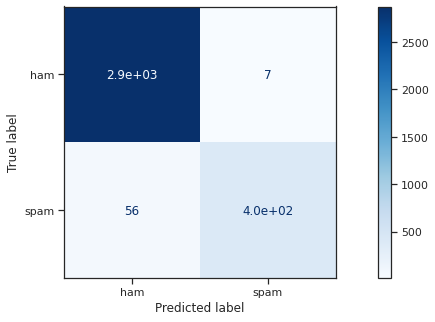

In [107]:
sentiment(TfidfVectorizer(ngram_range=(1,3)), LinearSVC())

Для метода К соседей найдем в цикле лучшее кол-во соседей

1


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.4685466377440347
2


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.19305856832971802
3


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.19305856832971802
4


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.08459869848156182
5


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.08459869848156182
6


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.03036876355748373
7


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9996531390912244
spam 	 0.5466377440347071
8


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9996531390912244
spam 	 0.4967462039045553
9


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9996531390912244
spam 	 0.6052060737527115
10


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 1.0
spam 	 0.5466377440347071
11


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9989594172736732
spam 	 0.6203904555314533
12


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9993062781824489
spam 	 0.561822125813449
13


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9993062781824489
spam 	 0.6247288503253796
14


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9996531390912244
spam 	 0.5726681127982647


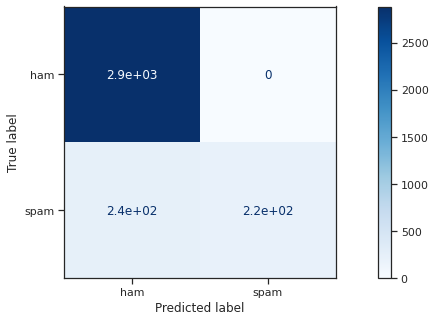

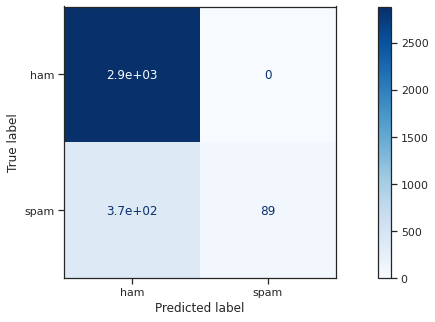

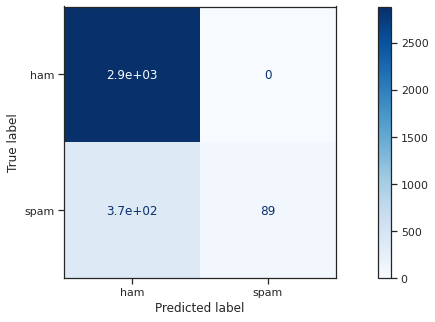

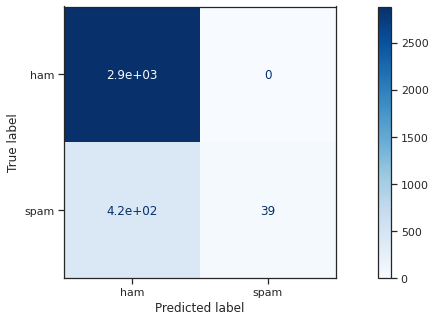

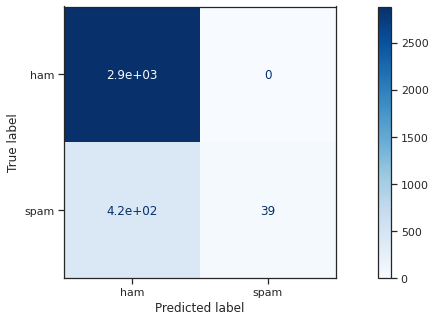

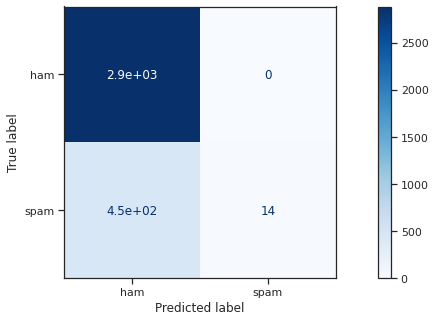

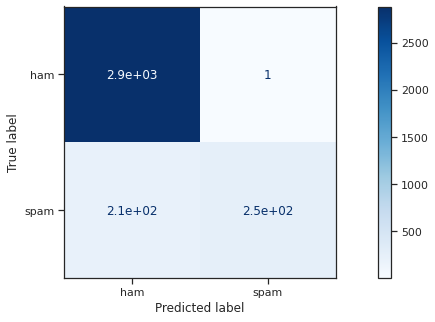

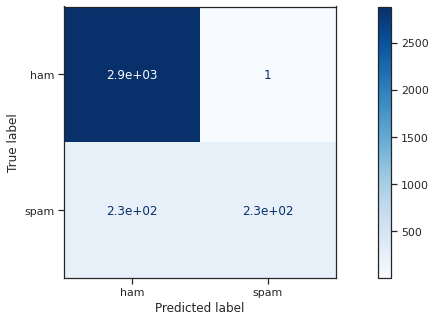

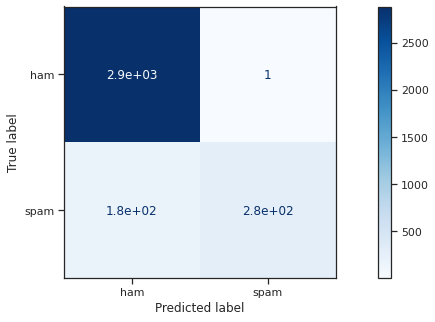

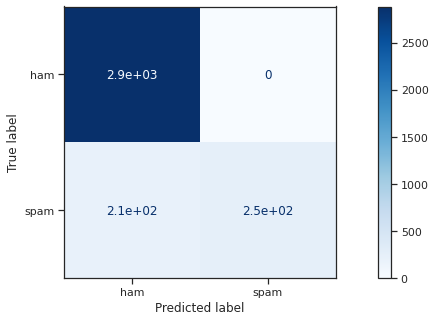

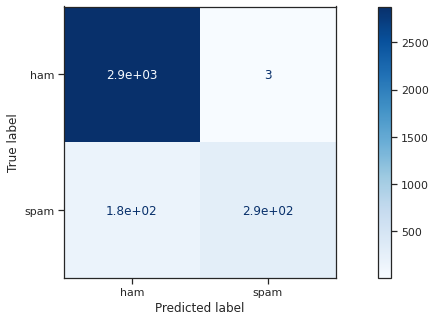

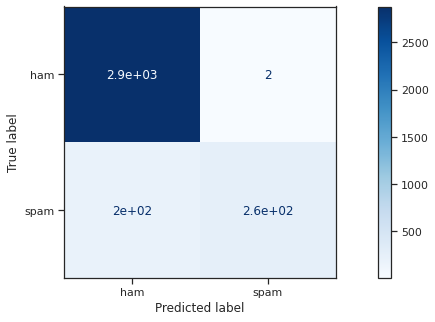

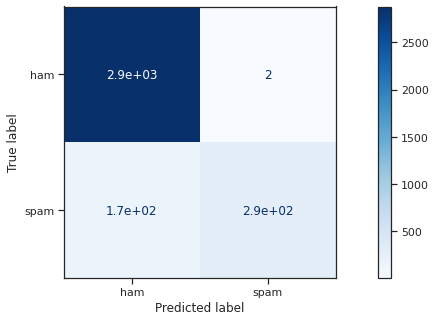

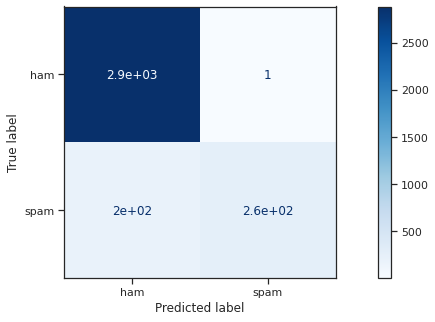

In [108]:
for k in range (1, 15):
     print(k)
     sentiment(TfidfVectorizer(ngram_range=(1,3)), KNeighborsClassifier(n_neighbors=k))

/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
ham 	 0.9993062781824489
spam 	 0.6247288503253796


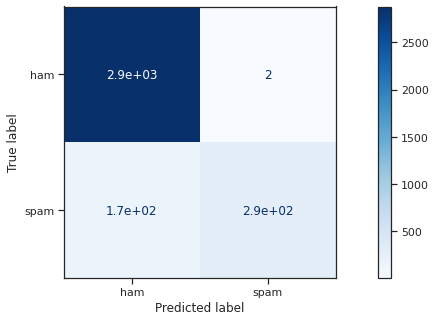

In [112]:
# Лучшее значение - 3 соседа
sentiment(TfidfVectorizer(ngram_range=(1,3)), KNeighborsClassifier(n_neighbors=13))

Метка 	 Accuracy
ham 	 0.9906347554630593
spam 	 0.8308026030368764


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


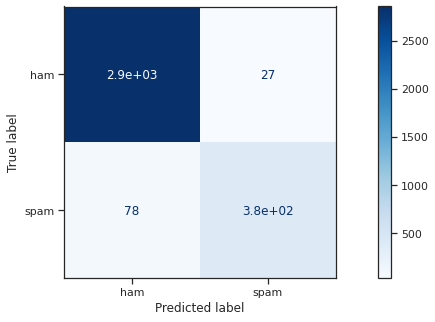

In [113]:
sentiment(TfidfVectorizer(), ComplementNB())

Метка 	 Accuracy
ham 	 0.9996531390912244
spam 	 0.7223427331887202


/home/sef/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


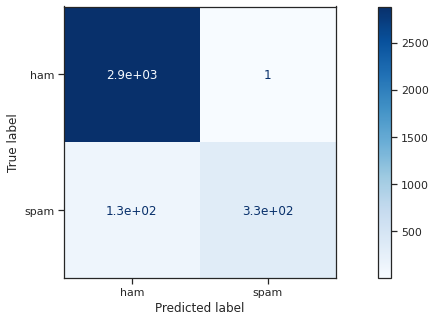

In [114]:
sentiment(TfidfVectorizer(), BernoulliNB())

## Вывод:
Поскольку выборка несбалансированная и все классификаторы делают незначительное количество ошибок при предсказании класса ham(не спам), то будем смотреть точность, с какой модели предсказывают класс spam.
Можно увидеть, что наилучший результат показал классификатор LinearSVR, а худший - метод К соседей с 14 соседями(также был проведен эксперимент, определяющий оптимальное кол-во соседей, но даже при этом этот метод оказался худшим).
Так же было подтверждено предположение, что лучшую точность среди Байесовских классификаторов покажет CNB, так как он предназначен для классов с дисбалансом.